In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
def StringToBytes(data):
    sum = 0
    arrbytes = bytes(data, 'utf-8')
    for i in arrbytes:
        sum = sum + i
    return(sum)

In [3]:
features, labels = [], []
training_files = ["dataset.csv"]

In [4]:
def scrape_data():
    global training_files
    global features
    global labels
    
    for fname in training_files:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 11):
                print("error data")
            else:
                data_list[5] = StringToBytes(data_list[5])
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    data_counter = Counter(labels)
    print(data_counter)
    
    over = SMOTE()
    under = RandomUnderSampler()
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    features, labels = pipeline.fit_resample(features, labels)
    
    data_counter = Counter(labels)
    print(data_counter)
    
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(features)
    features = scalar.transform(features)
    
    features = np.array(features).astype(np.float64)
    features = features.tolist()
    
    print(f"Size of feature dataset : {len(features)}")
    print(f"Size of feature dataset : {len(labels)}")
    print("Features first and last entries:\n\t", end = "")
    print(features[:1] + features[(len(features)-1):])
    print("Labels first and last entries:\n\t", end = "")
    print(labels[:1] + labels[(len(features)-1):])
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, stratify=labels, random_state = 0)
    
    return np.asarray(features_train), np.asarray(labels_train), np.asarray(features_test), np.asarray(labels_test)

In [5]:
def generate_model(shape):
    model = Sequential()

    model.add(Dense(256, input_dim=shape, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

In [6]:
data_train, label_train, data_eval, label_eval = scrape_data()

Counter({1: 200, 0: 200})
Counter({0: 200, 1: 200})
Size of feature dataset : 400
Size of feature dataset : 400
Features first and last entries:
	[[1.2020732429622507, 1.9718164478689237, -1.3991426654229087, 2.001928488600989, 0.0, 0.009644010863377905, 4.2482484026984935, -0.08706111741417988, 0.0, 0.1582360538943416], [-0.9817861331469772, -0.7166707859307148, 0.10884745742338835, -0.9595041868442611, 0.0, 0.009644010863377905, -0.23506029427228314, -1.4313485990113997, 0.0, -0.3972217921586348]]
Labels first and last entries:
	[0, 1]


C:\Users\H P VICTUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [7]:
model = generate_model(len(data_train[0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
checkpoint = ModelCheckpoint("dnnModel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [11]:
time_training_start = time.perf_counter()
history = model.fit(data_train, label_train, validation_split=0.2, epochs=100, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/100
1/8 [==>...........................] - ETA: 5s - loss: 0.6869 - accuracy: 0.5312
Epoch 00001: val_loss improved from inf to 0.61396, saving model to dnnModel.h5
8/8 [==============================] - 1s 20ms/step - loss: 0.6689 - accuracy: 0.6094 - val_loss: 0.6140 - val_accuracy: 1.0000
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6139 - accuracy: 0.8125
Epoch 00002: val_loss improved from 0.61396 to 0.47881, saving model to dnnModel.h5
8/8 [==============================] - 0s 10ms/step - loss: 0.5823 - accuracy: 0.8281 - val_loss: 0.4788 - val_accuracy: 1.0000
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5139 - accuracy: 0.8750
Epoch 00003: val_loss improved from 0.47881 to 0.27608, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 0.4367 - accuracy: 0.9609 - val_loss: 0.2761 - val_accuracy: 1.0000
Epoch 4/100
1/8 [==>...........................] - ETA: 0s - loss: 0.3573 - accuracy: 0.96

Epoch 28/100
1/8 [==>...........................] - ETA: 0s - loss: 2.8489e-06 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 4.3623e-04 - accuracy: 1.0000 - val_loss: 1.5772e-06 - val_accuracy: 1.0000
Epoch 29/100
1/8 [==>...........................] - ETA: 0s - loss: 7.6947e-05 - accuracy: 1.0000
Epoch 00029: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 1.3593e-04 - accuracy: 1.0000 - val_loss: 1.3852e-06 - val_accuracy: 1.0000
Epoch 30/100
1/8 [==>...........................] - ETA: 0s - loss: 6.5302e-05 - accuracy: 1.0000
Epoch 00030: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 11ms/step - loss: 4.9247e-04 - accuracy: 1.0000 - val_loss: 1.2601e-06 - val_accuracy: 1.0000
Epoch 31/100
1/8 [==>...........................

Epoch 54/100
1/8 [==>...........................] - ETA: 0s - loss: 3.5346e-04 - accuracy: 1.0000
Epoch 00054: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 10ms/step - loss: 1.0921e-04 - accuracy: 1.0000 - val_loss: 7.1027e-08 - val_accuracy: 1.0000
Epoch 55/100
1/8 [==>...........................] - ETA: 0s - loss: 1.6312e-05 - accuracy: 1.0000
Epoch 00055: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 10ms/step - loss: 4.3188e-05 - accuracy: 1.0000 - val_loss: 6.8374e-08 - val_accuracy: 1.0000
Epoch 56/100
1/8 [==>...........................] - ETA: 0s - loss: 1.1819e-06 - accuracy: 1.0000
Epoch 00056: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 1.2491e-04 - accuracy: 1.0000 - val_loss: 6.4750e-08 - val_accuracy: 1.0000
Epoch 57/100
1/8 [==>..........................

Epoch 80/100
1/8 [==>...........................] - ETA: 0s - loss: 6.1044e-06 - accuracy: 1.0000
Epoch 00080: val_loss did not improve from 0.00000
8/8 [==============================] - 0s 6ms/step - loss: 2.0467e-04 - accuracy: 1.0000 - val_loss: 1.6336e-08 - val_accuracy: 1.0000
Epoch 81/100
1/8 [==>...........................] - ETA: 0s - loss: 2.7367e-04 - accuracy: 1.0000
Epoch 00081: val_loss did not improve from 0.00000
8/8 [==============================] - 0s 6ms/step - loss: 5.7021e-05 - accuracy: 1.0000 - val_loss: 1.5697e-08 - val_accuracy: 1.0000
Epoch 82/100
1/8 [==>...........................] - ETA: 0s - loss: 5.8663e-06 - accuracy: 1.0000
Epoch 00082: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 2.2897e-04 - accuracy: 1.0000 - val_loss: 1.5047e-08 - val_accuracy: 1.0000
Epoch 83/100
1/8 [==>...........................] - ETA: 0s - loss: 4.7722e-07 - accuracy: 1.0000
Epoch 00083: val_

In [12]:
print(f'Time to training : {time.perf_counter() - time_training_start}')

Time to training : 8.4961098


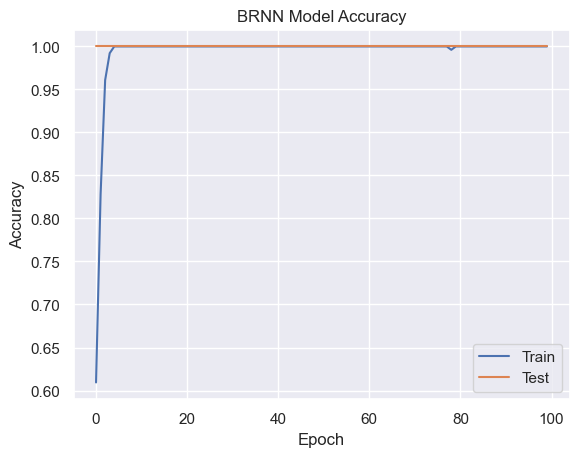

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

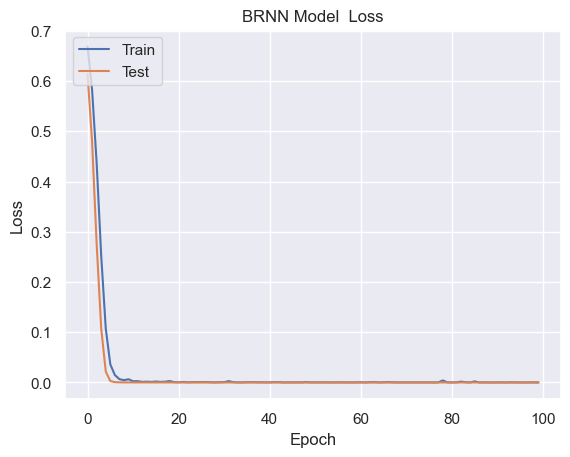

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [15]:
predict = model.predict(data_eval, verbose=1)

3/3 [==============================] - 0s 2ms/step


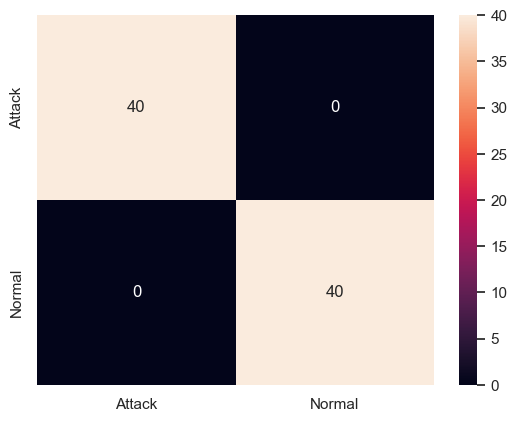

In [16]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = label_eval.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [17]:
scores = model.evaluate(data_eval, label_eval)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 [==============================] - 0s 4ms/step - loss: 1.7666e-09 - accuracy: 1.0000
accuracy: 100.00%


In [18]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [19]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=1.000


In [20]:
time_start = time.perf_counter()
predict = model.predict(data_eval[:1], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

1/1 [==============================] - 0s 23ms/step
Time elapse for prediction : 0.044364599999999754
[[1.]]
